In [0]:
import tensorflow
import numpy as np
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras import layers , optimizers , models

In [0]:
(train_data , train_targets) , (test_data , test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


In [0]:
train_data.shape

(404, 13)

In [0]:
test_data.shape

(102, 13)

In [0]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

# **PREPARING DATA**

In [0]:
# NORMALIZING OUR DATA

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

train_data -= mean
train_data /= std

In [0]:
train_data.shape[1]

13

# **BUILDING OUR NETWORK**

In [0]:
# since we need to instantiate model multiple times we will make a function of it
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64 , activation='relu' , input_shape = (13,)))
  model.add(layers.Dense(64 , activation='relu'))
  model.add(layers.Dense(1))

  model.compile(optimizer = 'rmsprop' , loss = 'mse' , metrics = ['mae'])
  return model

In [0]:
len(train_data) // 4

101

# **Validating our approach using K-fold validation**

In [0]:
''' 
k = 4
num_val_samples = 101 (404 // 4)

in loop till 4

1. val_data = train_data[(0 * 101) : (1 * 101) ]
   val_targets = train_data[(0 * 101) : (1 * 101) ]

2. val_data = train_data[(1 * 101) : (2 * 101) ]

3. val_data = train_data[(2 * 101) : (3 * 101) ]

4. val_data = train_data[(3 * 101) : (4 * 101) ]


in loop till 4

1. val_data = train_data[(0 * 101) : (1 * 101) ]
   val_targets = train_data[(0 * 101) : (1 * 101) ]

2. val_data = train_data[(1 * 101) : (2 * 101) ]

3. val_data = train_data[(2 * 101) : (3 * 101) ]

4. val_data = train_data[(3 * 101) : (4 * 101) ]
'''

In [0]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [0]:
all_scores

[2.7546825, 2.913079, 3.4848561, 3.1524775]

In [0]:
np.mean(all_scores)  #we are off by 3000$

3.076274

Let's try training the network for a bit longer: 500 epochs. To keep a record of how well the model did at each epoch, we will modify our training loop to save the per-epoch validation score log:

In [0]:
from tensorflow.keras import backend as k
# to clear memory
k.clear_session()

In [0]:
k = 4
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [0]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [0]:
np.mean(average_mae_history)

2.8177629

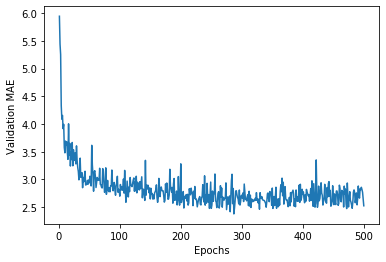

In [0]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()